# Transfer learning for NLP
## ALTEGRAD - Lab session 3
#### Moussa Kamal Eddine, Hadi Abdine (Dascim LIX)
##### November 2020

In [1]:
import math

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### The Model

In [2]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        '''
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value
         '''
        self.model_type = "Transformer"
        self.encoder = nn.Embedding(ntoken, nhid) # fill me, nhid = the dim_embed
        self.pos_encoder = PositionalEncoding(nhid, dropout) #fill me, the PositionalEncoding class is implemented in the next cell
        encoder_layers = nn.TransformerEncoderLayer(nhid, nhead, nhid, dropout) #fill me we assume nhid = d_model = dim_feedforward
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers) #fill me
        self.nhid = nhid
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.nhid) 
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        return output


class ClassificationHead(nn.Module):
    def __init__(self, nhid, nclasses):
        super(ClassificationHead, self).__init__()
        self.decoder = nn.Linear(nhid, nclasses)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        output = self.decoder(src)
        return output
    
class Model(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, nclasses, dropout=0.5):
        super(Model, self).__init__()
        self.base = TransformerModel(ntoken, nhead, nhid, nlayers, dropout)#fill me
        self.classifier = ClassificationHead(nhid, nclasses) #fill me 

    def forward(self, src, src_mask):
        # base model
        x = self.base.forward(src, src_mask) #fill me
        # classifier model
        output = self.classifier.forward(x)#fill me
        return output

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, nhid, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, nhid)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

Let's verify if our model works, by applying one inference step

In [4]:
ntokens = 100 #fill me # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21]]).to(device)
src_mask = model.base.generate_square_subsequent_mask(1).to(device)
out = model.forward(dummy_input, src_mask)

print(out.shape) # is it the right shape? -> yes (probability of the 6 tokens to follow the input 6 tokens, with 100 possible classes for each)

torch.Size([1, 6, 100])


In [5]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+-------------------------------------------------------------+------------+
|                           Modules                           | Parameters |
+-------------------------------------------------------------+------------+
|                     base.encoder.weight                     |   20000    |
|  base.transformer_encoder.layers.0.self_attn.in_proj_weight |   120000   |
|   base.transformer_encoder.layers.0.self_attn.in_proj_bias  |    600     |
| base.transformer_encoder.layers.0.self_attn.out_proj.weight |   40000    |
|  base.transformer_encoder.layers.0.self_attn.out_proj.bias  |    200     |
|       base.transformer_encoder.layers.0.linear1.weight      |   40000    |
|        base.transformer_encoder.layers.0.linear1.bias       |    200     |
|       base.transformer_encoder.layers.0.linear2.weight      |   40000    |
|        base.transformer_encoder.layers.0.linear2.bias       |    200     |
|        base.transformer_encoder.layers.0.norm1.weight       |    200     |

1008100

## Vocabulary and Tokenization

In [6]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
!head -5 dict.txt

--2020-12-01 19:41:34--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577587 (564K) [text/plain]
Saving to: ‘dict.txt’

dict.txt            100%[===================>] 564.05K  --.-KB/s    in 0.01s   

2020-12-01 19:41:35 (42.5 MB/s) - ‘dict.txt’ saved [577587/577587]

▁d 1
es 1
▁l 1
en 1
on 1


In [7]:
path_vocab = "dict.txt"
token2ind = {"<sos>": 0, "<pad>": 1, "<eos>": 2, "<oov>": 3} # the 4 first indices are reserved to special tokens
decay = len(token2ind)
with open(path_vocab, "r") as f:
    for idx, line in enumerate(f):
        word = line.split()[0].strip()
        token2ind[word] = idx + decay #fill me

ind2token = {ind: token for token, ind in token2ind.items()} #fill me

print(ind2token[1111])

▁trop


### Data Loader


In [8]:
import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Dataset(Dataset):
    def __init__(
        self,
        path_documents,
        path_labels=None,
        token2ind={},
        max_len=512,
        task="language_modeling",
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r") as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r") as f1:
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1]
        source_sequence = [self.token2ind["<sos>"]] + [
            self.token2ind[word] if word in self.token2ind else self.token2ind["<oov>"]
            for word in sequence[: self.max_len]
        ]
        if self.task == "language_modeling":
            target = source_sequence[1:]
            target.append(self.token2ind["<eos>"])
        elif self.task == "classification":
            target = [self.labels[index]]
        sample = {
            "source_sequence": torch.tensor(source_sequence),
            "target": torch.tensor(target),
        }
        return sample


def MyCollator(batch):
    source_sequences = pad_sequence(
        #we use padding to match the length of the sequences in the same batch
        [sample["source_sequence"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    target = pad_sequence(
        [sample["target"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    return source_sequences, target.reshape(-1)


def get_loader(
    path_documents,
    path_labels=None,
    token2ind={},
    max_len=512,
    batch_size=32,
    task="language_modeling",
):
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=512,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=MyCollator,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## The Training

In [9]:
from tqdm import tqdm
def train(
    path_data_train,
    path_labels_train=None,
    path_data_valid=None,
    save_interval=-1,
    log_interval=5,
    task="language_modeling",
    batch_size=32,
):
    model.train()
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        task=task,
        batch_size=batch_size,
    )
    
    losses = []
    with tqdm(total=len(data_loader)) as pbar:
        for idx, data in enumerate(data_loader): #step 1
            optimizer.zero_grad()
            src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
                device
            )
            input = data[0].to(device)
            output = model(input, src_mask) #step 2
            if task == 'classification':
                #last vector only
                output = output[-1] #fill me 
            output = output.view(-1, output.shape[-1])
            target = data[1] #fill me
            target = target.to(device)
            loss = criterion(output, target) #fill me, Cross entropy check next cells
            #fill me step 3
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient 
            #fill me step 4
            optimizer.step()
            total_loss += loss.item() 
            if idx % log_interval == 0 and idx > 0:
                cur_loss = total_loss / log_interval
                print(
                    "| epoch {:3d} | {:5d}/{:5d} steps | "
                    "loss {:5.5f} | ppl {:8.3f}".format(
                        epoch, idx, len(data_loader), cur_loss, math.exp(cur_loss),
                    )
                )
                losses.append(cur_loss)
                total_loss = 0
            pbar.update(1)
    return losses

In [33]:
ntokens = len(ind2token) #fill me # the size of vocabulary
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2 # for classification task only

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
count_parameters(model)

+-------------------------------------------------------------+------------+
|                           Modules                           | Parameters |
+-------------------------------------------------------------+------------+
|                     base.encoder.weight                     |  10000200  |
|  base.transformer_encoder.layers.0.self_attn.in_proj_weight |   120000   |
|   base.transformer_encoder.layers.0.self_attn.in_proj_bias  |    600     |
| base.transformer_encoder.layers.0.self_attn.out_proj.weight |   40000    |
|  base.transformer_encoder.layers.0.self_attn.out_proj.bias  |    200     |
|       base.transformer_encoder.layers.0.linear1.weight      |   40000    |
|        base.transformer_encoder.layers.0.linear1.bias       |    200     |
|       base.transformer_encoder.layers.0.linear2.weight      |   40000    |
|        base.transformer_encoder.layers.0.linear2.bias       |    200     |
|        base.transformer_encoder.layers.0.norm1.weight       |    200     |

21018401

In [11]:
# optimization paramerters

criterion = nn.CrossEntropyLoss(ignore_index=token2ind['<pad>'])
lr = 0.0003  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [12]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
path_data_train = "pretraining_subset.txt"

--2020-12-01 19:41:35--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10146460 (9.7M) [text/plain]
Saving to: ‘pretraining_subset.txt’

pretraining_subset. 100%[===================>]   9.68M  --.-KB/s    in 0.06s   

2020-12-01 19:41:36 (150 MB/s) - ‘pretraining_subset.txt’ saved [10146460/10146460]



In [13]:
#pretraining on a tiny subset
log_interval = 500
epochs = 2
for epoch in range(1, epochs + 1): #5
    train(
        path_data_train,
        save_interval=-1,
        task="language_modeling",
        batch_size=16,
        log_interval=log_interval,
    )

 16%|█▌        | 504/3125 [00:28<02:19, 18.84it/s]

| epoch   1 |   500/ 3125 steps | loss 7.33410 | ppl 1531.652


 32%|███▏      | 1003/3125 [00:56<02:04, 17.07it/s]

| epoch   1 |  1000/ 3125 steps | loss 6.47010 | ppl  645.547


 48%|████▊     | 1503/3125 [01:23<01:26, 18.80it/s]

| epoch   1 |  1500/ 3125 steps | loss 6.22080 | ppl  503.104


 64%|██████▍   | 2003/3125 [01:50<01:00, 18.55it/s]

| epoch   1 |  2000/ 3125 steps | loss 6.03337 | ppl  417.118


 80%|████████  | 2503/3125 [02:17<00:35, 17.38it/s]

| epoch   1 |  2500/ 3125 steps | loss 5.90512 | ppl  366.910


 96%|█████████▌| 3004/3125 [02:46<00:07, 16.45it/s]

| epoch   1 |  3000/ 3125 steps | loss 5.83983 | ppl  343.722


 16%|█▌        | 503/3125 [00:28<02:47, 15.68it/s]

| epoch   2 |   500/ 3125 steps | loss 5.52702 | ppl  251.395


 32%|███▏      | 1004/3125 [00:56<02:01, 17.49it/s]

| epoch   2 |  1000/ 3125 steps | loss 5.48928 | ppl  242.083


 48%|████▊     | 1503/3125 [01:25<01:32, 17.56it/s]

| epoch   2 |  1500/ 3125 steps | loss 5.43897 | ppl  230.206


 64%|██████▍   | 2003/3125 [01:53<01:15, 14.95it/s]

| epoch   2 |  2000/ 3125 steps | loss 5.41326 | ppl  224.361


 80%|████████  | 2504/3125 [02:21<00:34, 17.82it/s]

| epoch   2 |  2500/ 3125 steps | loss 5.38002 | ppl  217.027


 96%|█████████▌| 3004/3125 [02:49<00:06, 19.95it/s]

| epoch   2 |  3000/ 3125 steps | loss 5.36011 | ppl  212.749


100%|██████████| 3125/3125 [02:56<00:00, 17.68it/s]


## Text Generation


In [14]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt

model = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device)

#load the checkpoint
checkpoint = torch.load('pretrained_model_4layers.pt') 
#load state dict
model.load_state_dict(checkpoint['model_state_dict']) 

--2020-12-01 19:47:26--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88093955 (84M) [application/octet-stream]
Saving to: ‘pretrained_model_4layers.pt’

pretrained_model_4l 100%[===================>]  84.01M   361MB/s    in 0.2s    

2020-12-01 19:47:27 (361 MB/s) - ‘pretrained_model_4layers.pt’ saved [88093955/88093955]



<All keys matched successfully>

In [15]:
!pip install sentencepiece
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model

import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file='sentencepiece.french.model') #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

     |████████████████████████████████| 1.1MB 18.7MB/s 
--2020-12-01 19:47:31--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115362 (1.1M) [application/octet-stream]
Saving to: ‘sentencepiece.french.model’

sentencepiece.frenc 100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2020-12-01 19:47:31 (48.9 MB/s) - ‘sentencepiece.french.model’ saved [1115362/1115362]

['▁Bonjour', '▁les', '▁amis', '!']
Bonjour les amis!


In [16]:
def infer_next_token(sent):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind['<sos>']] + [token2ind[el] for el in sent_pieces]
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    next_token_ind = out[-1].argmax(-1)
    return next_token_ind, out
    
def infer_next_tokens(sent, max_len=50):
    # to be implemented
    max_len -= len(sent.split(' '))
    current_sentence, i = sent, 0
    while i < max_len:
        next_token_ind, _ = infer_next_token(current_sentence)
        encoded_next_word = ind2token[next_token_ind.item()]
        decoded_next_word = s.decode_pieces([encoded_next_word])
        if decoded_next_word == "<eos>":
            break
        current_sentence += ' ' + decoded_next_word
        i += 1
    return current_sentence

In [17]:
sent = "Bonjour les"
infer_next_tokens(sent)

'Bonjour les gens qui ont été très accueillants et sympathiques .'

### Supervised task

In [18]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label

path_data_train = "train.review.spm"
path_labels_train = "train.label"

path_data_valid = "test.review.spm"
path_labels_valid = "test.label"

--2020-12-01 19:47:31--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1495960 (1.4M) [text/plain]
Saving to: ‘train.review.spm’

train.review.spm    100%[===================>]   1.43M  --.-KB/s    in 0.03s   

2020-12-01 19:47:31 (44.3 MB/s) - ‘train.review.spm’ saved [1495960/1495960]

--2020-12-01 19:47:32--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting 

In [19]:
# a function to evaluate the validation accuracy of the model.
def evaluate_accuracy(data_loader):
    #to be implemented
    model.eval()
    total_correct_predictions = total_length = 0
    for idx, (input_data, target_data) in enumerate(data_loader):
        src_mask = model.base.generate_square_subsequent_mask(
            input_data.size(0)
        ).to(device)
        input_data = input_data.to(device)
        output = model(input_data, src_mask)
        output = output[-1]
        output = output.view(-1, output.shape[-1])
        max_prob_indices = output.argmax(-1)
        target_data = target_data.to(device)
        total_length += target_data.shape[0]
        correct_predictions = torch.sum(target_data == max_prob_indices)
        total_correct_predictions += correct_predictions.item()
    return total_correct_predictions / total_length

In [20]:
#save the base model to be loaded later in the fine-tuning phase
torch.save({"model_state_dict": model.base.state_dict(),}, "pretrained_model_4layers_no_class_head.pt")

In [30]:
from_scratch_settings = [True, False]

from_scratch_valid_acc = []
pretrained_valid_acc = []
lr = 0.0001

for from_scratch in from_scratch_settings:
    model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        #load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        #load state dict
        model.base.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("=====Training FROM SCRATCH======")
    epochs = 15
    for epoch in range(1, epochs + 1):
        train(
            path_data_train,
            path_labels_train,
            save_interval=-1,
            task='classification',
            batch_size=8,
            log_interval=50,
        )
        acc = evaluate_accuracy(
            get_loader(
                path_data_valid,
                path_labels_valid,
                token2ind=token2ind,
                batch_size=20,
                task='classification',
            )
        )
        print(f"\nCurrent accuracy: {acc}\n")
        if from_scratch:
            from_scratch_valid_acc.append(acc)
        else:
            pretrained_valid_acc.append(acc)

  2%|▏         | 3/200 [00:00<00:07, 26.31it/s]

=====Training FROM SCRATCH======


 28%|██▊       | 57/200 [00:01<00:03, 36.63it/s]

| epoch   1 |    50/  200 steps | loss 0.76233 | ppl    2.143


 54%|█████▍    | 108/200 [00:03<00:02, 36.39it/s]

| epoch   1 |   100/  200 steps | loss 0.71709 | ppl    2.048


 78%|███████▊  | 156/200 [00:04<00:01, 37.50it/s]

| epoch   1 |   150/  200 steps | loss 0.73031 | ppl    2.076


  2%|▏         | 3/200 [00:00<00:06, 29.88it/s]


Current accuracy: 0.5085



 28%|██▊       | 56/200 [00:01<00:03, 38.72it/s]

| epoch   2 |    50/  200 steps | loss 0.70172 | ppl    2.017


 53%|█████▎    | 106/200 [00:02<00:02, 36.54it/s]

| epoch   2 |   100/  200 steps | loss 0.65849 | ppl    1.932


 79%|███████▉  | 158/200 [00:04<00:01, 39.48it/s]

| epoch   2 |   150/  200 steps | loss 0.59100 | ppl    1.806


  2%|▎         | 5/200 [00:00<00:04, 39.29it/s]


Current accuracy: 0.6805



 28%|██▊       | 57/200 [00:01<00:03, 38.09it/s]

| epoch   3 |    50/  200 steps | loss 0.45437 | ppl    1.575


 54%|█████▍    | 108/200 [00:02<00:02, 36.35it/s]

| epoch   3 |   100/  200 steps | loss 0.40084 | ppl    1.493


 78%|███████▊  | 157/200 [00:04<00:01, 35.86it/s]

| epoch   3 |   150/  200 steps | loss 0.43416 | ppl    1.544


  2%|▏         | 4/200 [00:00<00:05, 37.00it/s]


Current accuracy: 0.7345



 28%|██▊       | 56/200 [00:01<00:04, 35.91it/s]

| epoch   4 |    50/  200 steps | loss 0.19241 | ppl    1.212


 52%|█████▎    | 105/200 [00:02<00:02, 36.34it/s]

| epoch   4 |   100/  200 steps | loss 0.17498 | ppl    1.191


 78%|███████▊  | 157/200 [00:04<00:01, 38.99it/s]

| epoch   4 |   150/  200 steps | loss 0.17527 | ppl    1.192


  2%|▏         | 4/200 [00:00<00:04, 39.63it/s]


Current accuracy: 0.726



 29%|██▉       | 58/200 [00:01<00:03, 38.62it/s]

| epoch   5 |    50/  200 steps | loss 0.01455 | ppl    1.015


 55%|█████▍    | 109/200 [00:02<00:02, 39.89it/s]

| epoch   5 |   100/  200 steps | loss 0.05165 | ppl    1.053


 78%|███████▊  | 156/200 [00:04<00:01, 37.61it/s]

| epoch   5 |   150/  200 steps | loss 0.02998 | ppl    1.030


  2%|▏         | 4/200 [00:00<00:05, 35.77it/s]


Current accuracy: 0.754



 28%|██▊       | 55/200 [00:01<00:03, 40.54it/s]

| epoch   6 |    50/  200 steps | loss 0.00844 | ppl    1.008


 54%|█████▍    | 108/200 [00:02<00:02, 37.88it/s]

| epoch   6 |   100/  200 steps | loss 0.00372 | ppl    1.004


 79%|███████▉  | 158/200 [00:04<00:01, 37.75it/s]

| epoch   6 |   150/  200 steps | loss 0.01595 | ppl    1.016


  2%|▎         | 5/200 [00:00<00:04, 43.20it/s]


Current accuracy: 0.745



 29%|██▉       | 58/200 [00:01<00:04, 34.70it/s]

| epoch   7 |    50/  200 steps | loss 0.00005 | ppl    1.000


 54%|█████▍    | 108/200 [00:02<00:02, 38.19it/s]

| epoch   7 |   100/  200 steps | loss 0.00464 | ppl    1.005


 78%|███████▊  | 155/200 [00:04<00:01, 40.78it/s]

| epoch   7 |   150/  200 steps | loss 0.00004 | ppl    1.000


  2%|▏         | 4/200 [00:00<00:05, 34.64it/s]


Current accuracy: 0.7475



 29%|██▉       | 58/200 [00:01<00:03, 38.55it/s]

| epoch   8 |    50/  200 steps | loss 0.00004 | ppl    1.000


 53%|█████▎    | 106/200 [00:02<00:02, 37.63it/s]

| epoch   8 |   100/  200 steps | loss 0.00002 | ppl    1.000


 78%|███████▊  | 157/200 [00:04<00:01, 38.38it/s]

| epoch   8 |   150/  200 steps | loss 0.00001 | ppl    1.000


  2%|▏         | 4/200 [00:00<00:05, 36.76it/s]


Current accuracy: 0.7385



 27%|██▋       | 54/200 [00:01<00:04, 34.48it/s]

| epoch   9 |    50/  200 steps | loss 0.00004 | ppl    1.000


 54%|█████▎    | 107/200 [00:02<00:02, 38.36it/s]

| epoch   9 |   100/  200 steps | loss 0.00001 | ppl    1.000


 78%|███████▊  | 156/200 [00:04<00:01, 37.81it/s]

| epoch   9 |   150/  200 steps | loss 0.00001 | ppl    1.000


  2%|▏         | 4/200 [00:00<00:05, 36.38it/s]


Current accuracy: 0.755



 28%|██▊       | 57/200 [00:01<00:03, 39.58it/s]

| epoch  10 |    50/  200 steps | loss 0.00001 | ppl    1.000


 52%|█████▎    | 105/200 [00:02<00:02, 35.40it/s]

| epoch  10 |   100/  200 steps | loss 0.00001 | ppl    1.000


 78%|███████▊  | 155/200 [00:04<00:01, 39.19it/s]

| epoch  10 |   150/  200 steps | loss 0.00001 | ppl    1.000


  2%|▏         | 4/200 [00:00<00:04, 39.85it/s]


Current accuracy: 0.7515



 29%|██▉       | 58/200 [00:01<00:03, 38.46it/s]

| epoch  11 |    50/  200 steps | loss 0.00001 | ppl    1.000


 53%|█████▎    | 106/200 [00:02<00:02, 39.75it/s]

| epoch  11 |   100/  200 steps | loss 0.00001 | ppl    1.000


 78%|███████▊  | 157/200 [00:04<00:01, 36.69it/s]

| epoch  11 |   150/  200 steps | loss 0.00001 | ppl    1.000


  2%|▏         | 4/200 [00:00<00:05, 35.49it/s]


Current accuracy: 0.756



 28%|██▊       | 55/200 [00:01<00:03, 37.50it/s]

| epoch  12 |    50/  200 steps | loss 0.00001 | ppl    1.000


 52%|█████▏    | 104/200 [00:02<00:02, 37.67it/s]

| epoch  12 |   100/  200 steps | loss 0.00001 | ppl    1.000


 77%|███████▋  | 154/200 [00:04<00:01, 34.47it/s]

| epoch  12 |   150/  200 steps | loss 0.00001 | ppl    1.000


  2%|▎         | 5/200 [00:00<00:05, 38.58it/s]


Current accuracy: 0.757



 28%|██▊       | 55/200 [00:01<00:03, 37.23it/s]

| epoch  13 |    50/  200 steps | loss 0.00001 | ppl    1.000


 53%|█████▎    | 106/200 [00:02<00:02, 36.96it/s]

| epoch  13 |   100/  200 steps | loss 0.00001 | ppl    1.000


 78%|███████▊  | 156/200 [00:04<00:01, 34.87it/s]

| epoch  13 |   150/  200 steps | loss 0.00001 | ppl    1.000


  2%|▏         | 4/200 [00:00<00:05, 32.96it/s]


Current accuracy: 0.756



 29%|██▉       | 58/200 [00:01<00:03, 36.07it/s]

| epoch  14 |    50/  200 steps | loss 0.00001 | ppl    1.000


 54%|█████▎    | 107/200 [00:02<00:02, 37.94it/s]

| epoch  14 |   100/  200 steps | loss 0.00000 | ppl    1.000


 78%|███████▊  | 157/200 [00:04<00:01, 38.47it/s]

| epoch  14 |   150/  200 steps | loss 0.00000 | ppl    1.000


  2%|▏         | 4/200 [00:00<00:05, 33.65it/s]


Current accuracy: 0.7545



 28%|██▊       | 57/200 [00:01<00:03, 41.09it/s]

| epoch  15 |    50/  200 steps | loss 0.00000 | ppl    1.000


 55%|█████▍    | 109/200 [00:02<00:02, 36.96it/s]

| epoch  15 |   100/  200 steps | loss 0.00000 | ppl    1.000


 78%|███████▊  | 157/200 [00:04<00:01, 36.42it/s]

| epoch  15 |   150/  200 steps | loss 0.00000 | ppl    1.000


100%|██████████| 200/200 [00:05<00:00, 37.41it/s]



Current accuracy: 0.755

=====PRETRAINED MODEL======


 29%|██▉       | 58/200 [00:01<00:03, 36.60it/s]

| epoch   1 |    50/  200 steps | loss 0.74040 | ppl    2.097


 54%|█████▎    | 107/200 [00:02<00:02, 38.65it/s]

| epoch   1 |   100/  200 steps | loss 0.66223 | ppl    1.939


 78%|███████▊  | 155/200 [00:04<00:01, 31.21it/s]

| epoch   1 |   150/  200 steps | loss 0.63008 | ppl    1.878


  2%|▏         | 4/200 [00:00<00:05, 35.07it/s]


Current accuracy: 0.7625



 28%|██▊       | 56/200 [00:01<00:04, 32.65it/s]

| epoch   2 |    50/  200 steps | loss 0.45943 | ppl    1.583


 52%|█████▎    | 105/200 [00:03<00:02, 35.43it/s]

| epoch   2 |   100/  200 steps | loss 0.43244 | ppl    1.541


 78%|███████▊  | 157/200 [00:04<00:01, 35.57it/s]

| epoch   2 |   150/  200 steps | loss 0.47243 | ppl    1.604


  2%|▎         | 5/200 [00:00<00:04, 40.47it/s]


Current accuracy: 0.797



 27%|██▋       | 54/200 [00:01<00:03, 37.08it/s]

| epoch   3 |    50/  200 steps | loss 0.27411 | ppl    1.315


 53%|█████▎    | 106/200 [00:02<00:02, 39.20it/s]

| epoch   3 |   100/  200 steps | loss 0.34152 | ppl    1.407


 77%|███████▋  | 154/200 [00:04<00:01, 34.94it/s]

| epoch   3 |   150/  200 steps | loss 0.37627 | ppl    1.457


  2%|▏         | 4/200 [00:00<00:06, 32.27it/s]


Current accuracy: 0.7845



 28%|██▊       | 56/200 [00:01<00:03, 37.39it/s]

| epoch   4 |    50/  200 steps | loss 0.23328 | ppl    1.263


 52%|█████▎    | 105/200 [00:02<00:02, 35.61it/s]

| epoch   4 |   100/  200 steps | loss 0.29208 | ppl    1.339


 78%|███████▊  | 155/200 [00:04<00:01, 34.00it/s]

| epoch   4 |   150/  200 steps | loss 0.15162 | ppl    1.164


  2%|▏         | 4/200 [00:00<00:06, 32.57it/s]


Current accuracy: 0.798



 28%|██▊       | 56/200 [00:01<00:04, 33.16it/s]

| epoch   5 |    50/  200 steps | loss 0.22560 | ppl    1.253


 54%|█████▍    | 108/200 [00:02<00:02, 38.19it/s]

| epoch   5 |   100/  200 steps | loss 0.10937 | ppl    1.116


 77%|███████▋  | 154/200 [00:04<00:01, 35.63it/s]

| epoch   5 |   150/  200 steps | loss 0.26133 | ppl    1.299


  2%|▏         | 4/200 [00:00<00:05, 33.87it/s]


Current accuracy: 0.8015



 28%|██▊       | 56/200 [00:01<00:03, 38.02it/s]

| epoch   6 |    50/  200 steps | loss 0.09859 | ppl    1.104


 54%|█████▍    | 108/200 [00:02<00:02, 36.85it/s]

| epoch   6 |   100/  200 steps | loss 0.02596 | ppl    1.026


 78%|███████▊  | 155/200 [00:04<00:01, 36.02it/s]

| epoch   6 |   150/  200 steps | loss 0.08864 | ppl    1.093


  2%|▏         | 4/200 [00:00<00:05, 35.28it/s]


Current accuracy: 0.7915



 30%|██▉       | 59/200 [00:01<00:03, 38.83it/s]

| epoch   7 |    50/  200 steps | loss 0.00220 | ppl    1.002


 53%|█████▎    | 106/200 [00:02<00:02, 38.76it/s]

| epoch   7 |   100/  200 steps | loss 0.03040 | ppl    1.031


 78%|███████▊  | 156/200 [00:04<00:01, 37.80it/s]

| epoch   7 |   150/  200 steps | loss 0.02571 | ppl    1.026


  2%|▏         | 4/200 [00:00<00:05, 34.21it/s]


Current accuracy: 0.7915



 29%|██▉       | 58/200 [00:01<00:03, 35.62it/s]

| epoch   8 |    50/  200 steps | loss 0.04319 | ppl    1.044


 54%|█████▎    | 107/200 [00:02<00:02, 39.41it/s]

| epoch   8 |   100/  200 steps | loss 0.01876 | ppl    1.019


 78%|███████▊  | 155/200 [00:04<00:01, 35.60it/s]

| epoch   8 |   150/  200 steps | loss 0.00092 | ppl    1.001


  2%|▏         | 4/200 [00:00<00:05, 36.97it/s]


Current accuracy: 0.789



 28%|██▊       | 56/200 [00:01<00:03, 38.40it/s]

| epoch   9 |    50/  200 steps | loss 0.00335 | ppl    1.003


 54%|█████▎    | 107/200 [00:02<00:02, 35.22it/s]

| epoch   9 |   100/  200 steps | loss 0.01705 | ppl    1.017


 78%|███████▊  | 157/200 [00:04<00:01, 35.90it/s]

| epoch   9 |   150/  200 steps | loss 0.00008 | ppl    1.000


  2%|▏         | 4/200 [00:00<00:05, 36.18it/s]


Current accuracy: 0.7815



 28%|██▊       | 55/200 [00:01<00:04, 35.38it/s]

| epoch  10 |    50/  200 steps | loss 0.00001 | ppl    1.000


 55%|█████▍    | 109/200 [00:02<00:02, 37.55it/s]

| epoch  10 |   100/  200 steps | loss 0.00346 | ppl    1.003


 78%|███████▊  | 157/200 [00:04<00:01, 35.76it/s]

| epoch  10 |   150/  200 steps | loss 0.01855 | ppl    1.019


  2%|▏         | 4/200 [00:00<00:05, 38.93it/s]


Current accuracy: 0.7865



 27%|██▋       | 54/200 [00:01<00:04, 35.84it/s]

| epoch  11 |    50/  200 steps | loss 0.00002 | ppl    1.000


 53%|█████▎    | 106/200 [00:02<00:02, 39.84it/s]

| epoch  11 |   100/  200 steps | loss 0.00002 | ppl    1.000


 78%|███████▊  | 156/200 [00:04<00:01, 37.52it/s]

| epoch  11 |   150/  200 steps | loss 0.00002 | ppl    1.000


  2%|▏         | 3/200 [00:00<00:06, 29.23it/s]


Current accuracy: 0.784



 28%|██▊       | 56/200 [00:01<00:03, 36.26it/s]

| epoch  12 |    50/  200 steps | loss 0.00004 | ppl    1.000


 54%|█████▍    | 108/200 [00:02<00:02, 40.10it/s]

| epoch  12 |   100/  200 steps | loss 0.00491 | ppl    1.005


 78%|███████▊  | 156/200 [00:04<00:01, 36.31it/s]

| epoch  12 |   150/  200 steps | loss 0.01199 | ppl    1.012


  2%|▏         | 4/200 [00:00<00:05, 38.28it/s]


Current accuracy: 0.786



 28%|██▊       | 56/200 [00:01<00:03, 36.65it/s]

| epoch  13 |    50/  200 steps | loss 0.00002 | ppl    1.000


 53%|█████▎    | 106/200 [00:02<00:02, 37.56it/s]

| epoch  13 |   100/  200 steps | loss 0.00001 | ppl    1.000


 78%|███████▊  | 156/200 [00:04<00:01, 37.61it/s]

| epoch  13 |   150/  200 steps | loss 0.00000 | ppl    1.000


  2%|▏         | 4/200 [00:00<00:05, 35.56it/s]


Current accuracy: 0.7825



 28%|██▊       | 57/200 [00:01<00:04, 33.66it/s]

| epoch  14 |    50/  200 steps | loss 0.00000 | ppl    1.000


 53%|█████▎    | 106/200 [00:02<00:02, 38.88it/s]

| epoch  14 |   100/  200 steps | loss 0.00002 | ppl    1.000


 78%|███████▊  | 157/200 [00:04<00:01, 39.24it/s]

| epoch  14 |   150/  200 steps | loss 0.00000 | ppl    1.000


  2%|▎         | 5/200 [00:00<00:05, 38.77it/s]


Current accuracy: 0.7835



 28%|██▊       | 55/200 [00:01<00:04, 34.56it/s]

| epoch  15 |    50/  200 steps | loss 0.00000 | ppl    1.000


 52%|█████▎    | 105/200 [00:02<00:02, 34.60it/s]

| epoch  15 |   100/  200 steps | loss 0.00000 | ppl    1.000


 78%|███████▊  | 157/200 [00:04<00:01, 37.86it/s]

| epoch  15 |   150/  200 steps | loss 0.00000 | ppl    1.000


100%|██████████| 200/200 [00:05<00:00, 35.93it/s]



Current accuracy: 0.7885



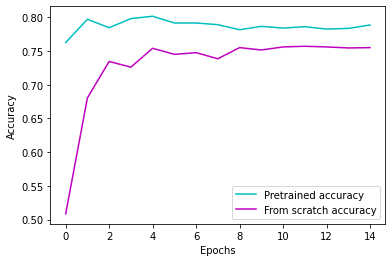

In [32]:
#Visualize the accuracy
import matplotlib.pyplot as plt
plt.plot(pretrained_valid_acc, 'c', label="Pretrained accuracy")
plt.plot(from_scratch_valid_acc, 'm', label="From scratch accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()